# Customisable Prediction Accuracy Plots

In this notebook, any specified model which adheres to the sklearn API can be fitted across customisable training windows starting in 2021, with predictions made and plotted for the week after the training window. Models are persisted to disk for quickly repeatable runs.

In [1]:
import os
from joblib import dump, load
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from tscv import GapRollForward
from tqdm.notebook import tqdm

# --- notebook parameters: import, choose model, set hyperparameters
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
    AdaBoostRegressor, HistGradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor

DATA_PATH = '../data/sa/merged_interpolated.csv'
TRAIN_BEGIN = '2020-01-01'
TRAIN_MIN_SIZE = 48 * 365   # change for expanding window
TRAIN_MAX_SIZE = 48 * 365   # change for expanding window (np.inf)
TEST_MIN_SIZE = 48 * 7
TEST_MAX_SIZE = 48 * 7
TEST_FINAL_N = None         # set to None for rolling test window, or n to test final observations
ROLL_SIZE = 48 * 7

MODEL_SELECTION = 'hgb'
MODELS_DEFINITION = {
    'rf': {
        'class': RandomForestRegressor,
        'kwargs': {'n_jobs': 8}
    },
    'hgb': {
        'class': HistGradientBoostingRegressor,
        'kwargs': {} # capable of quantile loss, l2reg
    },
    'gb': {'class': GradientBoostingRegressor},
    'ada': {'class': AdaBoostRegressor},
    'knn': {'class': KNeighborsRegressor}
}
MODEL_DIR = f'../models/sa/{MODEL_SELECTION}'
# --- end notebook parameters

In [2]:

MODEL = MODELS_DEFINITION[MODEL_SELECTION]['class']
MODEL_KWARGS = MODELS_DEFINITION[MODEL_SELECTION].get('kwargs', {})
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# import and preprocess SA data
df = pd.read_csv(os.path.relpath(DATA_PATH))
df.datetime = df.datetime.astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9

df_subset = df[df.datetime >= TRAIN_BEGIN]

# specify rolling training window strategy
tscv = GapRollForward(min_train_size=TRAIN_MIN_SIZE, max_train_size=TRAIN_MAX_SIZE,
                      min_test_size=TEST_MIN_SIZE, max_test_size=TEST_MAX_SIZE,
                      roll_size=ROLL_SIZE)
print(sum(1 for i in tscv.split(df_subset)), 'models to be loaded/trained')

# load persisted models if they exist, otherwise train/persist new models and predict
prdfs = []
for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df_subset))):
    if TEST_FINAL_N:
        test_ind = range(-TEST_FINAL_N, 0)

    X_train, X_test = df_subset.iloc[train_ind, X_inds], df_subset.iloc[test_ind, X_inds]
    y_train, y_test = df_subset.iloc[train_ind, y_ind], df_subset.iloc[test_ind, y_ind]

    # train or load
    begin, end = df_subset.iloc[[train_ind[0], train_ind[-1]], 0].dt.date
    argstring = '_'.join([f'{k}={v}' for k, v in MODEL_KWARGS.items()])
    model_filename = os.path.join(MODEL_DIR, f'{begin}_{end}_{argstring}.joblib')
    try:
        model = load(model_filename)
    except FileNotFoundError:
        model = MODEL(**MODEL_KWARGS)
        model.fit(X_train, y_train)
        dump(model, model_filename)

    # predict
    prd = model.predict(X_test)
    prdf = pd.DataFrame({'datetime': df_subset.iloc[test_ind, 0], 
                        'model': i,
                        'train_end': end,
                        'predicted': prd,
                        'net_load': y_test})
    prdfs.append(prdf)

predictions = pd.concat(prdfs)
predictions['residual'] = predictions['predicted'] - predictions['net_load']
predictions['pe'] = predictions['residual'] / predictions['net_load']
predictions['ape'] = predictions['pe'].abs()
predictions['sqerr'] = predictions['residual'] ** 2
prediction_summary = predictions.groupby('train_end').describe()

113 models to be loaded/trained


0it [00:00, ?it/s]

[Text(0.5, 1.0, 'Squared Error Quantiles')]

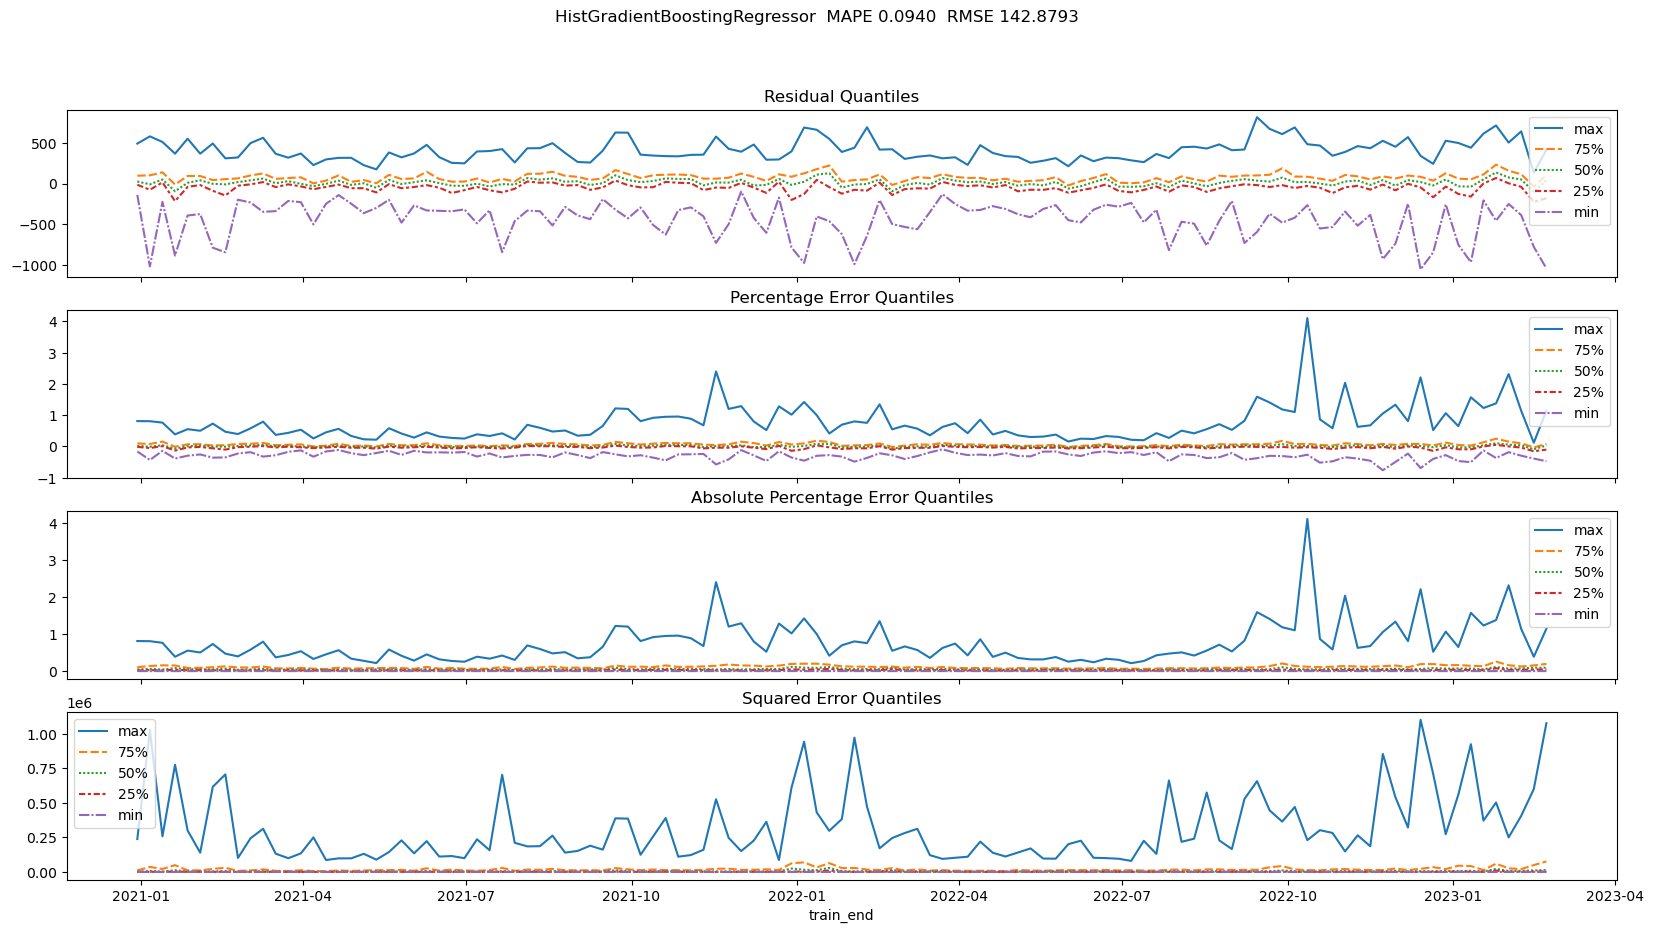

In [7]:
# to display in plot title
model_type = str(MODEL).split("'")[1].split(".")[-1]
mape = predictions["ape"].mean()
rmse = predictions["sqerr"].mean() ** 0.5

fig, ax = plt.pyplot.subplots(4, 1, figsize=(20, 10), sharex=True)
fig.suptitle(f'{model_type}  MAPE {mape:.4f}  RMSE {rmse:.4f}')

sns.lineplot(prediction_summary['residual'][['max', '75%', '50%', '25%', 'min']], ax=ax[0])
ax[0].set(title='Residual Quantiles')

sns.lineplot(prediction_summary['pe'][['max', '75%', '50%', '25%', 'min']], ax=ax[1])
ax[1].set(title='Percentage Error Quantiles')

sns.lineplot(prediction_summary['ape'][['max', '75%', '50%', '25%', 'min']], ax=ax[2])
ax[2].set(title='Absolute Percentage Error Quantiles')

sns.lineplot(prediction_summary['sqerr'][['max', '75%', '50%', '25%', 'min']], ax=ax[3])
ax[3].set(title='Squared Error Quantiles')